# Dog Leg Version 3
### Improvements to be made:
- More exhaustive data collection
- Gather Injection parameters at each step
- Make Data collection more flexible
- Make the Dog Leg run faster, as fast as possible

#### Imports

In [15]:
import Master as M
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import Tag_Database as Tags

Client = M.Make_Client('10.50.0.10')

#### Creating a read function that adds a list of tags to read and appends to the read list

#### User Defined Variables

In [17]:
start_time = time.time()

Pulsing_Status = bool(M.Read(Client, Tags.Pulsing_Output, Bool = True))

Move_To_Optimum = False

# The tag list below is structured as multiple lists. Each of these lists contain the tag and whether or not that tag should be averaged
Tag_List = [[Tags.WF6H, False], [Tags.WF7H, False], [Tags.WF6V, False], [Tags.WF7V, False], \
            [Tags.Emitted_Current, True], [Tags.Recirculator_Halfway, True], \
            [Tags.Recirculator_Bypass, True], [Tags.CU_V, False], [Tags.SRF_Pt, False]]

Threshold_Percent = 0 #Float. The percentage of beam that we want to collect in order to turn the Dog Leg around

Zoom_In_Factor = 1 #This is how much we want to zoomn in if we are interested in an artifact at the center of the dog leg or want higher precision in the center

Scale_Factor = 0.91 #This is how much we want to scale off of the excel documents used prior to Dog Legs

Read_Steps = 40 #Integer. Number of steps to be taken in the Dog Leg. Must be an integer

if Pulsing_Status:
    count = 25 #Integer. How many points will be recorded at each step and averaged over if pulsing
    sleep_time = 0.010 #Float.(ms)Sleep for 20 ms, this is tested to not overload PLC or give redundant data
else:
    count = 10 #Non-pulsing count of steps to take
    sleep_time = 0.010 #Non-pulsing sleep time

Delta_6 = 0.384*Scale_Factor/Zoom_In_Factor #Change in Window Frame 6 Values throughout the test, standard is 0.384 from Dog Leg Excel sheets (01/01/2020)
Delta_7 = 0.228*Scale_Factor/Zoom_In_Factor #Change in Window Frame 7 Values throughout the test, standard is 0.228 from Dog Leg Excel sheets (01/01/2020)

#### Beginning of run snapshot

In [18]:
a = time.time()
Emission_Setpoint = M.Read(Client, Tags.Emission_Set)
Emission_Actual = M.Read(Client, Tags.Emitted_Current, Average = True, count = count, sleep_time = sleep_time)
WF6H_Start = M.Read(Client,Tags.WF6H) #Starting value for Window Frame 6 Horizontal
WF7H_Start = M.Read(Client,Tags.WF7H) #Starting value for Window Frame 7 Horizontal
WF6V_Start = M.Read(Client,Tags.WF6V) #Starting value for Window Frame 6 Horizontal
WF7V_Start = M.Read(Client,Tags.WF7V) #Starting value for Window Frame 7 Horizontal
IR_Temp = M.Read(Client, Tags.IR_Temp)
VA_Temp = M.Read(Client, Tags.VA_Temp)
V0_Setpoint = M.Read(Client, Tags.V0_SP)
V0_Read = M.Read(Client, Tags.V0_Read)
Cathode_V = M.Read(Client, Tags.Voltage_Read)
Cathode_I = M.Read(Client, Tags.Current_Read)
Cathode_Z = M.Read(Client, Tags.Impedance_Read)
Cathode_P = M.Read(Client, Tags.Power_Read)
CU_Gun_Pf = M.Read(Client, Tags.CU_Pf)
CU_Gun_Pr = M.Read(Client, Tags.CU_Pr)
CU_Gun_Pt = M.Read(Client, Tags.CU_Pt)
CU_Gun_V = M.Read(Client, Tags.CU_V)
BH_Gun_Pf = M.Read(Client, Tags.BH_Pf)
BH_Gun_Pr = M.Read(Client, Tags.BH_Pr)
BH_Gun_Pt = M.Read(Client, Tags.BH_Pt)
SRF_Pf = M.Read(Client, Tags.SRF_Pf)
SRF_Pr = M.Read(Client, Tags.SRF_Pr)
SRF_Pt = M.Read(Client, Tags.SRF_Pt)
Pulse_Freq = M.Read(Client, Tags.Pulse_Frequency)
Pulse_Duty = M.Read(Client, Tags.Pulse_Duty)

EC = M.Read(Client, Tags.Emitted_Current)
print(time.time()-a)
start_time = time.time()

#Summing the start current of the two dumps
Start_Current = (M.Read(Client, Tags.Recirculator_Halfway, Average = True, count = count,sleep_time = sleep_time) + \
                 M.Read(Client, Tags.Recirculator_Bypass, Average = True, count = count,sleep_time = sleep_time))

H_Broken = V_Broken = False #Creating the check tag for the Horizontal dog leg, starting out as false as no errors could have been raised yet

0.4385669231414795


#### Creating the data structure

In [19]:
Full_Data_Set = list()
print(Full_Data_Set)
WF6H_Tag = Tags.WF6H
WF7H_Tag = Tags.WF7H
WF6V_Tag = Tags.WF6V
WF7V_Tag = Tags.WF7V

[]


## Start the Dog Leg Loop
### Starting Horizontal Walk
#### To the right

In [20]:
print("Right Displacement")

Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))

for Right_Steps in range(1, Read_Steps + 1):
    if Right_Steps != 1: #Don't check on the first run due to absence of Window Frame write values
        #Comparing the current value to the last write value, if it is different, this updates the break loop for both Horizontal and Vertical
        if abs(M.Read(Client,WF6H_Tag) - WF6H_Write_Value) or abs(M.Read(Client,WF7H_Tag) - WF7H_Write_Value) >= 0.001: #WF6H Check
            H_Broken = V_Broken = True
            print("Loop Broken")
            #break   
            
    WF6H_Write_Value = WF6H_Start + (Delta_6/Read_Steps)*Right_Steps #Calculated value to walk 6 to the right
    WF7H_Write_Value = WF7H_Start - (Delta_7/Read_Steps)*Right_Steps #Calculated value to walk 7 to the left
    
    M.Write(Client, WF6H_Tag, WF6H_Write_Value) #Writing to 6h
    M.Write(Client, WF7H_Tag, WF7H_Write_Value) #Writing to 7h
    
    a = time.time()
    Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))
    print(time.time()-a) 
    if abs(Full_Data_Set[-1][5] + Full_Data_Set[-1][6]) < abs(Threshold_Percent*Start_Current*.01): #Checking our threshold
        break
print("Moving to center")

M.Ramp_Two(Client, WF6H_Tag, WF7H_Tag, Magnet_1_Stop = WF6H_Start, Magnet_2_Stop = WF7H_Start, Resolution = Right_Steps//2, sleep_time = sleep_time) #Moves back to the start in hald of the same # of steps taken

Right Displacement


AttributeError: 'ModbusIOException' object has no attribute 'registers'

#### To the left

In [7]:
print("Left Displacement")

Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))

for Left_Steps in range(1, Read_Steps + 1):
    if H_Broken or V_Broken == True:
        break
    if Left_Steps != 1: #Don't check on the first run due to absence of Window Frame write values
        #Comparing the current value to the last write value, if it is different, this updates the break loop for both Horizontal and Vertical
        if abs(M.Read(Client,WF6H_Tag) - WF6H_Write_Value) or abs(M.Read(Client,WF7H_Tag) - WF7H_Write_Value) >= 0.001: #WF6H Check
            H_Broken = V_Broken = True
            print("Loop Broken")
            #break
            
    WF6H_Write_Value = WF6H_Start - (Delta_6/Read_Steps)*Left_Steps
    WF7H_Write_Value = WF7H_Start + (Delta_7/Read_Steps)*Left_Steps
    
    M.Write(Client, WF6H_Tag, WF6H_Write_Value)
    M.Write(Client, WF7H_Tag, WF7H_Write_Value)
    
    Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))
    
    if abs(Full_Data_Set[-1][5] + Full_Data_Set[-1][6]) < abs(Threshold_Percent*Start_Current*.01): #Checking our threshold
        break
        
print("Moving to center")

M.Ramp_Two(Client, WF6H_Tag, WF7H_Tag, Magnet_1_Stop = WF6H_Start, Magnet_2_Stop = WF7H_Start, Resolution = Left_Steps//2, sleep_time = sleep_time)

Left Displacement
Moving to center


### Starting the vertical walk
#### Upward

In [8]:
print("Upward Displacement")

Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))

for Upward_Steps in range(1, Read_Steps + 1):
    if H_Broken or V_Broken == True:
        break
    if Upward_Steps != 1: #Don't check on the first run due to absence of Window Frame write values
        #Comparing the current value to the last write value, if it is different, this updates the break loop for both Horizontal and Vertical
        if abs(M.Read(Client,WF6H_Tag) - WF6H_Write_Value) or abs(M.Read(Client,WF7H_Tag) - WF7H_Write_Value) >= 0.001: #WF6H Check
            H_Broken = V_Broken = True
            print("Loop Broken")
            #break
            
    WF6V_Write_Value = WF6V_Start + (Delta_6/Read_Steps)*Upward_Steps
    WF7V_Write_Value = WF7V_Start - (Delta_7/Read_Steps)*Upward_Steps
    
    M.Write(Client, WF6V_Tag, WF6V_Write_Value)
    M.Write(Client, WF7V_Tag, WF7V_Write_Value)
    
    Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))
    
    if abs(Full_Data_Set[-1][5] + Full_Data_Set[-1][6]) < abs(Threshold_Percent*Start_Current*.01): #Checking our threshold
        break

print("Moving to center")

M.Ramp_Two(Client, WF6V_Tag, WF7V_Tag, Magnet_1_Stop = WF6V_Start, Magnet_2_Stop = WF7V_Start, Resolution = Upward_Steps//2, sleep_time = sleep_time)

Upward Displacement
Moving to center


#### Downward

In [9]:
print("Downward Displacement")

Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))

for Downward_Steps in range(1, Read_Steps + 1):
    if H_Broken or V_Broken == True:
        break
    if Downward_Steps != 1: #Don't check on the first run due to absence of Window Frame write values
        #Comparing the current value to the last write value, if it is different, this updates the break loop for both Horizontal and Vertical
        if abs(M.Read(Client,WF6H_Tag) - WF6H_Write_Value) or abs(M.Read(Client,WF7H_Tag) - WF7H_Write_Value) >= 0.001: #WF6H Check
            H_Broken = V_Broken = True
            print("Loop Broken")
            #break
            
    WF6V_Write_Value = WF6V_Start - (Delta_6/Read_Steps)*Downward_Steps
    WF7V_Write_Value = WF7V_Start + (Delta_7/Read_Steps)*Downward_Steps
    
    M.Write(Client, WF6V_Tag, WF6V_Write_Value)
    M.Write(Client, WF7V_Tag, WF7V_Write_Value)
    
    Full_Data_Set.append(M.Gather(Client, Full_Data_Set, Tag_List, count = count, sleep_time = sleep_time))
    
    if abs(Full_Data_Set[-1][5] + Full_Data_Set[-1][6]) < abs(Threshold_Percent*Start_Current*.01): #Checking our threshold
        break

print("Moving to center")

M.Ramp_Two(Client, WF6V_Tag, WF7V_Tag, Magnet_1_Stop = WF6V_Start, Magnet_2_Stop = WF7V_Start, Resolution = Downward_Steps//2, sleep_time = sleep_time)

Downward Displacement
Moving to center


### Saving and Plotting
#### Saving

In [10]:
now = datetime.today().strftime('%y%m%d_%H%M') #Taking the current time in YYMMDD_HHmm format to save the plot and the txt file


with open(now + ".txt",'w') as f: #Opening a file with the current date and time
    f.write("EC_Setpoint: {:.4f}, EC_Read: {:.4f}, IR_Temp: {:.4f}, VA_Temp: {:.4f}".format(Emission_Setpoint, Emission_Actual, \
                                                    IR_Temp, VA_Temp) + '\n')
    f.write("V0_Set: {:.4f}, V0_Read {:.4f}, Pulse_Bool: {:.4f}, Rise_Threshold: {:.4f}".format(V0_Setpoint, V0_Read, \
                                                    Pulsing_Status, Threshold_Percent) + '\n')
    
    f.write("Cathode Voltage: {:.4f}, Cathode Current: {:.4f}, Cathode Impedance: {:.4f}, Cathode Power: {:.4f}".format(Cathode_V, Cathode_I, \
                                                    Cathode_Z, Cathode_P) + '\n')
    f.write("Cu Gun Pf: {:.4f}, Cu Gun Pr: {:.4f}, Cu Gun Pt: {:.4f}, Cu Gun V: {:.4f}".format(CU_Gun_Pf, CU_Gun_Pr, \
                                                    CU_Gun_Pt, CU_Gun_V) + '\n')
    f.write("BH Pf: {:.4f}, BH Pr: {:.4f}, BH Pt: {:.4f}, Pulse Frequency: {:.4f}".format(BH_Gun_Pf, BH_Gun_Pr, \
                                                    BH_Gun_Pt, Pulse_Freq) + '\n')
    f.write("SRF Pf: {:.4f}, SRF Pr: {:.4f}, SRF Pt: {:.4f}, Pulse Duty: {:.4f}".format(SRF_Pf, SRF_Pr, \
                                                    SRF_Pt, Pulse_Duty) + '\n')
    f.write("WF6H (A), WF7H(A), WF6V(A), WF7V(A), Avg'd Emitted Current(mA), Avg'd Loop Mid(mA), Avg'd Loop Bypass(mA), ")
    f.write("Cu Gun (kV), SRF Pt (dBm)" + '\n')
    for line in Full_Data_Set:
        f.write(str(line).strip("([])")+'\n') #Writing each line in that file
    f.close() #Closing the file to save it

#### Plotting

This took 88.3 Seconds to run


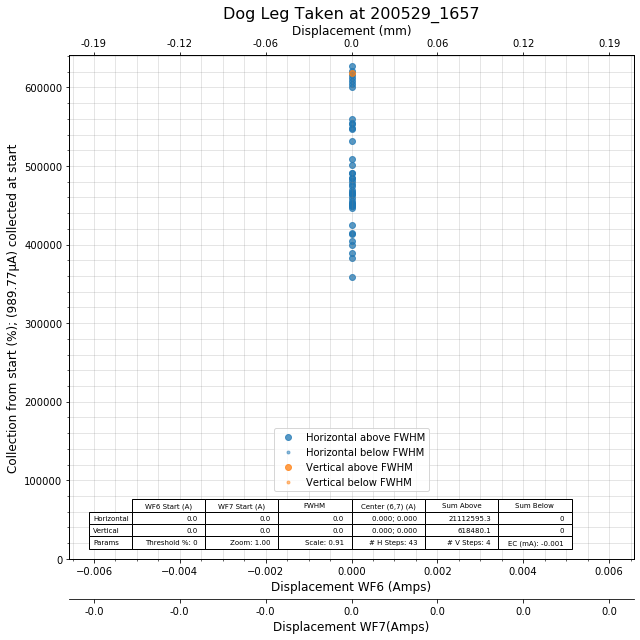

In [11]:
Full_Data_Array = np.array(Full_Data_Set) #Converting from a list to an array

Horizontal_6 = Full_Data_Array[:(Right_Steps + 2 + Left_Steps),0] #Defining the steps on in the horizontal
Horizontal_7 = Full_Data_Array[:(Right_Steps + 2 + Left_Steps),1]

Vertical_6 = Full_Data_Array[(Right_Steps + 2 + Left_Steps):,2] #Defining the steps only in the Vertical
Vertical_7 = Full_Data_Array[(Right_Steps + 2 + Left_Steps):,3]
Dump_1 = Full_Data_Array[:,4] #Dump 1 all values
Dump_2 = Full_Data_Array[:,5] #Dump 2 all values
Emitted_Current = Full_Data_Array[:,6] #Emitted current all values
Dump_Sum = Dump_1 + Dump_2 #All dump values

### Plotting

def convert_to_mms(locs): #Converting the xlabels to mm
    new_list = []
    for i in locs:
        new_list.append(round(i/.384*12,2)) #Our conversion formula
    return new_list

def Delta6_7(locs): #Converting the 6 values to the same displacement in 7
    new_list = []
    for i in locs:
        new_list.append(round(i/.384*.228,2))
    return new_list

#Dump Sum into percent from start
Horizontal_Percent = Dump_Sum[:(Right_Steps + 2 + Left_Steps)]/Emitted_Current[:(Right_Steps + 2 + Left_Steps)]*100 #Defining the percents
Vertical_Percent = Dump_Sum[(Right_Steps + 2 + Left_Steps):]/Emitted_Current[(Right_Steps + 2 + Left_Steps):]*100

#FWHM of all of our data
Horizontal_Above, Horizontal_Below, H_Width, Center_Value_6H, H_Goodsum, H_Badsum = M.FWHM(Horizontal_6, Horizontal_Percent, extras = True) #FWHM Calclations
Vertical_Above, Vertical_Below, V_Width, Center_Value_6V, V_Goodsum, V_Badsum = M.FWHM(Vertical_6, Vertical_Percent, extras = True)
_,_1,_2,Center_Value_7H,_3, _4 = M.FWHM(Horizontal_7, Horizontal_Percent, extras = True)
_,_1,_2,Center_Value_7V,_3, _4 = M.FWHM(Vertical_7, Vertical_Percent, extras = True)


#Plotting
plt.figure(figsize = (9,9)) #Changing the figure to be larger

ax1 = plt.subplot(1,1,1)
ax1.scatter(Horizontal_6 - Horizontal_6[0], Horizontal_Above, label = 'Horizontal above FWHM',color = 'C0', alpha = 0.75) #Plotting 6H Above FWHM
ax1.scatter(Horizontal_6 - Horizontal_6[0], Horizontal_Below, label = 'Horizontal below FWHM', color = 'C0', alpha = 0.5, marker = '.') #Plotting 6H below FWHM
ax1.scatter(Vertical_6 - Vertical_6[0], Vertical_Above, label = 'Vertical above FWHM', color = 'C1', alpha = 0.75) #Plotting 6V above FWHM
ax1.scatter(Vertical_6 - Vertical_6[0], Vertical_Below, label = 'Vertical below FWHM', color = 'C1', alpha = 0.5, marker = '.') #plotting 6V Below FWHM
ax1.set_xlabel("Displacement WF6 (Amps)", fontsize = 12) #Setting xlabel
ax1.set_ylabel("Collection from start (%); ({0:.2f}\u03BCA) collected at start".format(1000*abs(min(Dump_Sum))), fontsize = 12) #Making the y axis label
ax1.set_title("Dog Leg Taken at " + now, fontsize = 16) #Making the title 
ax1.legend(bbox_to_anchor = (0.5,0.27), loc = 'upper center') #Adding the legend and placing it in the bottom center of the plot

ax1.minorticks_on() #Turning on the minor axis
ax1.grid(True,alpha = 0.25,which = 'both',color = 'gray') #Making the grid (and making it more in the background)

locs = ax1.get_xticks() #Grabbing the xticks from that axis

ax2 = ax1.twiny() #Copying axis

ax2.set_xticks(locs) #Setting xticks to same position
ax2.set_xticklabels(convert_to_mms(locs)) #Converting to mm
ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
ax2.spines['top'].set_position(('outward', 0)) #Setting the ticks to go out of graph area
ax2.set_xlabel('Displacement (mm)', fontsize = 12) #Label
ax2.set_xlim(ax1.get_xlim()) #Setting to the same limit as prior axis

ax3 = ax1.twiny() #Repeat for axis 3

ax3.set_xticks(locs)
ax3.set_xticklabels(Delta6_7(locs))
ax3.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax3.spines['bottom'].set_position(('outward', 40))
ax3.set_xlabel('Displacement WF7(Amps)', fontsize = 12)
ax3.set_xlim(ax1.get_xlim())

col_labels = ['WF6 Start (A)','WF7 Start (A)','FWHM', 'Center (6,7) (A)', 'Sum Above', 'Sum Below'] #Making the table column names
row_labels = ['Horizontal','Vertical','Params'] #making the table row names
table_vals = [[round(WF6H_Start,3), round(WF7H_Start,3), round(H_Width,3), "{:.3f}; {:.3f}".format(Center_Value_6H, Center_Value_7H), round(H_Goodsum,1), round(H_Badsum,1)],
              [round(WF6V_Start,3) , round(WF7V_Start,3), round(V_Width,3), "{:.3f}; {:.3f}".format(Center_Value_6V, Center_Value_7V) , round(V_Goodsum,1), round(V_Badsum,1)],
              ["Threshold %: {:.0f}".format(Threshold_Percent),"Zoom: {:.2f}".format(Zoom_In_Factor),"Scale: {:.2f}".format(Scale_Factor),
               "# H Steps: {:.0f}".format(Right_Steps + 2 + Left_Steps),"# V Steps: {:.0f}".format(Upward_Steps + 2 + Downward_Steps), "EC (mA): {:.3f}".format(EC)]] #Setting values

the_table = plt.table(cellText=table_vals, #Putting the table onto the plot
                  colWidths = [0.13]*6,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='lower center', zorder = 1) #Putting in the center and in front of all else

plt.gca().set_ylim(bottom=-2) #Making sure the plot always goes below 0 in the y axis

plt.tight_layout() #configuring plot to not cut off extraneous objects like title and x axes

plt.savefig(now + "_graph.svg",transparent = True) #Saving the figure to a plot

if Move_To_Optimum == True: #If the option to move to the optimum is true, then move the magnets there
    print("Moving to optimum for 6 and 7")
    M.Ramp_Two(Client, WF6H_Tag, WF6V_Tag, Magnet_1_Stop = Center_Value_6H, Magnet_2_Stop = Center_Value_6V, Resolution = Read_Steps, sleep_time = .100)
    M.Ramp_Two(Client, WF7H_Tag, WF7V_Tag, Magnet_1_Stop = Center_Value_7H, Magnet_2_Stop = Center_Value_7V, Resolution = Read_Steps, sleep_time = .100)


print("This took {0:.1f} Seconds to run".format(time.time() - start_time)) #Printing the amount of time the dog leg took

plt.show()

In [60]:
import re
string = "WF6H(A): 2.304"
print("".join(filter(str.isdigit, string)))
print(re.compile(r'[^\d.]+').sub('',string))

62304
62.304
